In [1]:
from __future__ import print_function, division
from collections import Counter
import csv
import numpy as np
import random
import sys
import os
import copy
import time
from datetime import datetime,timedelta
from math import log, sqrt
import pandas as pd
import distance
from keras.models import load_model
import matplotlib.pyplot as plt
from jellyfish._jellyfish import damerau_levenshtein_distance

# 1.Read file

In [95]:
eventlog = "env_permit.csv"
eventlog_name = "env_permit"

In [96]:
csvfile = open('../data/%s' % eventlog, 'r')
spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
next(spamreader, None)  # skip the headers
ascii_offset = 161

# 2.Process Data

In [97]:
csvfile = open('../data/%s' % eventlog, 'r')
spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
next(spamreader, None)  # skip the headers
ascii_offset = 161

lastcase = ''
line = ''
firstLine = True
lines = []
caseids = []
timeseqs = []
timeseqs2 = []
times = []
times2 = []
numlines = 0
casestarttime = None
lasteventtime = None
for row in spamreader:
    t = time.strptime(row[2], "%Y-%m-%d %H:%M:%S")
    if row[0]!=lastcase:
        caseids.append(row[0])
        casestarttime = t
        lasteventtime = t
        lastcase = row[0]
        if not firstLine:
            lines.append(line)
            timeseqs.append(times)
            timeseqs2.append(times2)
        line = ''
        times = []
        numlines+=1
    line+=chr(int(row[1])+ascii_offset)
    timesincelastevent = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(lasteventtime))
    timesincecasestart = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(casestarttime))
    timediff = 86400 * timesincelastevent.days + timesincelastevent.seconds
    timediff2 = 86400 * timesincecasestart.days + timesincecasestart.seconds
    times.append(timediff)
    times2.append(timediff2)
    lasteventtime = t
    firstLine = False

# add last case
lines.append(line)
timeseqs.append(times)
timeseqs2.append(times2)
numlines+=1

#average time between events
divisor = np.mean([item for sublist in timeseqs for item in sublist])
print('divisor: {}'.format(divisor))
#average time between current and starting events
divisor2 = np.mean([item for sublist in timeseqs2 for item in sublist])
print('divisor2: {}'.format(divisor2))

divisor: 211117.80678559278
divisor2: 411304.5465415836


In [98]:
elems_per_fold = int(round(numlines/3))
fold1 = lines[:elems_per_fold]
fold1_c = caseids[:elems_per_fold]
fold1_t = timeseqs[:elems_per_fold]
fold1_t2 = timeseqs2[:elems_per_fold]

fold2 = lines[elems_per_fold:2*elems_per_fold]
fold2_c = caseids[elems_per_fold:2*elems_per_fold]
fold2_t = timeseqs[elems_per_fold:2*elems_per_fold]
fold2_t2 = timeseqs2[elems_per_fold:2*elems_per_fold]

lines = fold1 + fold2
caseids = fold1_c + fold2_c
lines_t = fold1_t + fold2_t
lines_t2 = fold1_t2 + fold2_t2

step = 1
sentences = []
softness = 0
next_chars = []
lines = list(map(lambda x: x+'!',lines))
maxlen = max(map(lambda x: len(x),lines))

chars = list(map(lambda x : set(x),lines))
chars = list(set().union(*chars))
chars.sort()
target_chars = copy.copy(chars)
chars.remove('!')
print('total chars: {}, target chars: {}'.format(len(chars), len(target_chars)))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
target_char_indices = {c: i for i, c in enumerate(target_chars)}
target_indices_char = {i: c for i, c in enumerate(target_chars)}
print(indices_char)

total chars: 4, target chars: 5
{0: '¢', 1: '§', 2: '©', 3: 'ª'}


In [99]:
lastcase = ''
line = ''
firstLine = True
lines = []
caseids = []
timeseqs = []  # relative time since previous event
timeseqs2 = [] # relative time since case start
timeseqs3 = [] # absolute time of previous event
times = []
times2 = []
times3 = []
numlines = 0
casestarttime = None
lasteventtime = None
csvfile = open('../data/%s' % eventlog, 'r')
spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
next(spamreader, None)  # skip the headers
for row in spamreader:
    t = time.strptime(row[2], "%Y-%m-%d %H:%M:%S")
    if row[0]!=lastcase:
        caseids.append(row[0])
        casestarttime = t
        lasteventtime = t
        lastcase = row[0]
        if not firstLine:        
            lines.append(line)
            timeseqs.append(times)
            timeseqs2.append(times2)
            timeseqs3.append(times3)
        line = ''
        times = []
        numlines+=1
    line+=chr(int(row[1])+ascii_offset)
    timesincelastevent = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(lasteventtime))
    timesincecasestart = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(casestarttime))
    midnight = datetime.fromtimestamp(time.mktime(t)).replace(hour=0, minute=0, second=0, microsecond=0)
    timesincemidnight = datetime.fromtimestamp(time.mktime(t))-midnight
    timediff = 86400 * timesincelastevent.days + timesincelastevent.seconds
    timediff2 = 86400 * timesincecasestart.days + timesincecasestart.seconds
    #timediff = log(timediff+1)
    times.append(timediff)
    times2.append(timediff2)
    times3.append(datetime.fromtimestamp(time.mktime(t)))
    lasteventtime = t
    firstLine = False

# add last case
lines.append(line)
timeseqs.append(times)
timeseqs2.append(times2)
timeseqs3.append(times3)
numlines+=1

### Using last 1/3 as test set

In [100]:
fold3 = lines[2*elems_per_fold:]
fold3_c = caseids[2*elems_per_fold:]
fold3_t = timeseqs[2*elems_per_fold:]
fold3_t2 = timeseqs2[2*elems_per_fold:]
fold3_t3 = timeseqs3[2*elems_per_fold:]
#fold3_t4 = timeseqs4[2*elems_per_fold:]

lines = fold3
caseids = fold3_c
lines_t = fold3_t
lines_t2 = fold3_t2
lines_t3 = fold3_t3
#lines_t4 = fold1_t4 + fold2_t4

# set parameters
predict_size = 1

# 3.Prediction

In [101]:
# load model, set this to the model generated by train.py
import joblib
model = joblib.load(f'output_files/models/{eventlog_name}_RF_best_model.pkl')

In [102]:
# define helper functions
# Define the function to encode the input sequence
# 2 dimensional output for passing to the Random Forest model for prediction
def encode(sentence, times, times3, maxlen=maxlen):
    num_features = len(chars)+5
    X = np.zeros((1, maxlen, num_features), dtype=np.float32)
    leftpad = maxlen - len(sentence)
    times2 = np.cumsum(times)
    for t, char in enumerate(sentence):
        midnight = times3[t].replace(hour=0, minute=0, second=0, microsecond=0)
        timesincemidnight = times3[t] - midnight
        multiset_abstraction = Counter(sentence[:t+1])
        for c in chars:
            if c == char:
                X[0, t + leftpad, char_indices[c]] = 1
        X[0, t + leftpad, len(chars)] = t + 1
        X[0, t + leftpad, len(chars) + 1] = times[t] / divisor
        X[0, t + leftpad, len(chars) + 2] = times2[t] / divisor2
        X[0, t + leftpad, len(chars) + 3] = timesincemidnight.seconds / 86400
        X[0, t + leftpad, len(chars) + 4] = times3[t].weekday() / 7

    # Reshape X to be 2-dimensional
    X = X.reshape((X.shape[0], -1))

    return X

In [103]:
# Define the function to get the predicted symbol from the output vector
def getSymbol(predictions):
    maxIndex = np.argmax(predictions)
    symbol = target_indices_char[maxIndex]
    return symbol

In [104]:
one_ahead_gt = []
one_ahead_pred = []

two_ahead_gt = []
two_ahead_pred = []

three_ahead_gt = []
three_ahead_pred = []

In [105]:
# make predictions
with open(f'output_files/results/{eventlog_name}_RF_next_activity_%s' % eventlog, 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(["CaseID", "Prefix length", "Groud truth", "Predicted", "Levenshtein", "Damerau", "Jaccard", "Ground truth times", "Predicted times", "RMSE", "MAE"])
    for prefix_size in range(2,maxlen):
        print(prefix_size)
        for line, caseid, times, times3 in zip(lines, caseids, lines_t, lines_t3):
            times.append(0)
            cropped_line = ''.join(line[:prefix_size])
            cropped_times = times[:prefix_size]
            cropped_times3 = times3[:prefix_size]
            if '!' in cropped_line:
                continue # make no prediction for this case, since this case has ended already
            ground_truth = ''.join(line[prefix_size:prefix_size+predict_size])
            ground_truth_t = times[prefix_size:prefix_size+predict_size]
            predicted = ''
            for i in range(predict_size):
                if len(ground_truth)<=i:
                    continue
                enc = encode(cropped_line, cropped_times, cropped_times3)
                #print(enc)
                y = model.predict(enc)
                y_char = y
                #print('y_char:',y_char)
                prediction = getSymbol(y_char)   
                #print('prediction:' + prediction)
                cropped_line += prediction
                #print('cropped_line:' + cropped_line)
                if prediction == '!': # end of case was just predicted, therefore, stop predicting further into the future
                    print('! predicted, end case')
                    break
                predicted += prediction
             
            output = []
            
            if len(ground_truth)>0:
                output.append(caseid)
                output.append(prefix_size)
                output.append(str(ground_truth).encode("utf-8"))
                output.append(str(predicted).encode("utf-8"))
                output.append(1 - distance.nlevenshtein(predicted, ground_truth))
                dls = 1 - (damerau_levenshtein_distance(str(predicted), str(ground_truth)) / max(len(predicted),len(ground_truth)))
                if dls<0:
                    dls=0 # we encountered problems with Damerau-Levenshtein Similarity on some linux machines where the default character encoding of the operating system caused it to be negative, this should never be the case
                output.append(dls)
                output.append(1 - distance.jaccard(predicted, ground_truth))

                spamwriter.writerow(output)

2
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predic

! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicte

! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicte

! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicte

# 4.Evaluation

In [106]:
from sklearn.metrics import accuracy_score, classification_report
ground_truth = []
predicted = []
with open(f'output_files/results/{eventlog_name}_RF_next_activity_%s' % eventlog) as file:
    reader = csv.reader(file, delimiter=",")
    # Skip the header
    next(reader, None)
    for row in reader:
        # we do not evaluate the end activity of the case
        if len(row) >= 4 and row[2] and row[3]:
            ground_truth.append(row[2])
            predicted.append(row[3])

In [107]:
accuracy = accuracy_score(ground_truth, predicted)
print("Next activity accuracy: ", accuracy)
print(classification_report(ground_truth, predicted))

Next activity accuracy:  0.3289504036908881
              precision    recall  f1-score   support

         b''       0.00      0.00      0.00         0
 b'\xc2\xa2'       0.00      0.00      0.00        97
 b'\xc2\xa3'       0.00      0.00      0.00        54
 b'\xc2\xa5'       0.00      0.00      0.00        22
 b'\xc2\xa6'       0.00      0.00      0.00         6
 b'\xc2\xa7'       0.45      0.77      0.57      1848
 b'\xc2\xa8'       0.00      0.00      0.00         6
 b'\xc2\xa9'       0.00      0.00      0.00      1515
 b'\xc2\xaa'       0.00      0.00      0.00       787

    accuracy                           0.33      4335
   macro avg       0.05      0.09      0.06      4335
weighted avg       0.19      0.33      0.24      4335



C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metr

In [108]:
# convert classification report to dataframe
report = classification_report(ground_truth, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()

# Save DataFrame to CSV file
df.to_csv(f'output_files/results/{eventlog_name}_RF_Report.csv')

C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I541451\Anaconda3\lib\site-packages\sklearn\metr

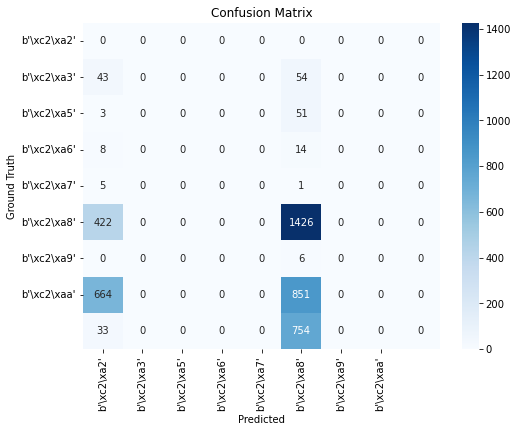

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(ground_truth, predicted)

# Get class labels from ground truth
classes = np.unique(ground_truth)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()